In [1]:
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math

In [2]:
mydb = mysql.connector.connect(host='localhost',
                               user='mimicuser',
                               passwd='mimic',
                               database='mimiciiiv13',
                              auth_plugin='mysql_native_password')

First approach to query mysql from python

In [3]:
cursor = mydb.cursor(buffered=True)

Check that MySQL connection works properly

In [269]:
df = pd.read_sql_query("SELECT * FROM LABEVENTS LIMIT 5;", mydb)
df

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,1,2,163353,51143,2138-07-17 20:48:00,0,0.0,%,None
1,2,2,163353,51144,2138-07-17 20:48:00,0,0.0,%,None
2,3,2,163353,51146,2138-07-17 20:48:00,0,0.0,%,None
3,4,2,163353,51200,2138-07-17 20:48:00,0,0.0,%,None
4,5,2,163353,51221,2138-07-17 20:48:00,0,0.0,%,abnormal


Here is how we are going to test the mutual information idea:

- create a temporary table that combines LABEVENTS(SUBJECT_ID, ITEMID, CHARTTIME), Lab2Hpo(NEGATED, MAP_TO), D_LABEVENTS(LOINC)
- define patient phenotype: having a phenotype > 3 times 
  

create a small dataset of 100 encounters (88 distinct patient) for testing with the following code:

"create table test as (with adm as (select distinct subject_id, hadm_id from admissions limit 100) select combined.* from adm left join combined on adm.subject_id = combined.subject_id and adm.hadm_id = combined.hadm_id);"

## EDA before analyzing synergy

There are some questions we need to further explore. 

* How many times did each patient get admitted into ICU?

From the following query, we can see that about 84% patients were admitted only once, 11% were admitted twice, and the rest 5% were admitted three times or more. We could just focus on the 84%. This will make our task easier as we do not need to worry about effects from other admissions.  

In [277]:
admissions_per_patient = pd.read_sql_query("WITH adm_per_patient AS \
    (SELECT count(*) as adm_time FROM ADMISSIONS GROUP BY SUBJECT_ID) \
    SELECT adm_time, count(*) as patient_n FROM adm_per_patient GROUP BY adm_time ORDER BY patient_n DESC", mydb)
admissions_per_patient['percent'] = admissions_per_patient.patient_n / np.sum(admissions_per_patient.patient_n)
admissions_per_patient[0:10]

,adm_time,patient_n,percent
0,1,38983,0.837984
1,2,5160,0.110920
2,3,1342,0.028848
3,4,508,0.010920
4,5,246,0.005288
5,6,113,0.002429
6,7,51,0.001096
7,8,31,0.000666
8,9,26,0.000559
9,10,14,0.000301


* How many abnormal phenotypes does each patient have at each admission?

From the histogram, we can see that most patients have ~20 abnormal phenotypes. 

In [278]:
cursor.execute("DROP TEMPORARY TABLE IF EXISTS combined")
cursor.execute('''
        CREATE TEMPORARY TABLE IF NOT EXISTS combined AS 
        SELECT LABEVENTS.ROW_ID, LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, LABEVENTS.ITEMID, LABEVENTS.CHARTTIME, 
        LabHpo.NEGATED, LabHpo.MAP_TO 
        FROM LABEVENTS JOIN LabHpo on LABEVENTS.ROW_ID = LabHpo.ROW_ID
   ''')
cursor.execute("CREATE INDEX combined_negated ON combined (NEGATED)")

abnormPerPatientAdm = pd.read_sql_query("WITH abnormal_per_patient_adm AS \
(SELECT SUBJECT_ID, HADM_ID, count(*) AS abnormal_n \
FROM combined WHERE NEGATED = 'F' GROUP BY SUBJECT_ID, HADM_ID) \
SELECT abnormal_n, count(*) AS n FROM abnormal_per_patient_adm GROUP BY abnormal_n ORDER BY n DESC ", mydb)

In [9]:
abnormPerPatientAdm.loc[abnormPerPatientAdm.n > 500, :]

,abnormal_n,n
0,8,1465
1,7,1446
2,9,1306
3,6,1260
4,10,1031
5,5,1026
6,1,915
7,4,823
8,11,783
9,12,734


A better way is to plot this.

In [51]:
abnormalities_per_patient_adm = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, count(*) AS abnormal_n \
FROM combined WHERE NEGATED = 'F' GROUP BY SUBJECT_ID, HADM_ID", mydb)

In [11]:
abnormalities_per_patient_adm.abnormal_n.describe()

count    73678.000000
mean       127.217731
std        207.226446
min          1.000000
25%         24.000000
50%         67.000000
75%        142.000000
max       9467.000000
Name: abnormal_n, dtype: float64

In [12]:
bins = pd.cut(abnormalities_per_patient_adm.abnormal_n, bins = [-1, 0, 25, 50, 75, 100, 125, 150, 175, 200, 3000, 10000])
hist_data = abnormalities_per_patient_adm.groupby(bins).size()

In [13]:
hist_data.values

array([    0, 19284, 10949,  9581,  7447,  5339,  3707,  2785,  2252,
       12316,    18])

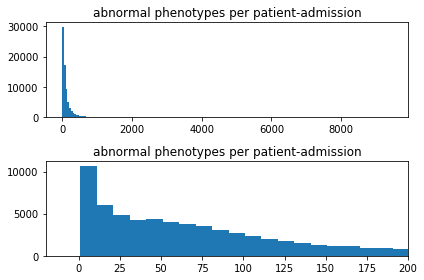

In [14]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.hist(abnormalities_per_patient_adm.abnormal_n, 
        bins = np.arange(0, np.max(abnormalities_per_patient_adm.abnormal_n), 50))
plt.title('abnormal phenotypes per patient-admission')
ax = fig.add_subplot(212)
ax.hist(abnormalities_per_patient_adm.abnormal_n, 
        bins = np.arange(-9, np.max(abnormalities_per_patient_adm.abnormal_n), 10))
plt.xlim((-20, 200))
plt.title('abnormal phenotypes per patient-admission')
plt.tight_layout()
plt.show()

* How to assign that a patient has a phenotype at one admission?

We look at how many times does each abnormal phenotype occur for each patient admission.

In [15]:
pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, MAP_TO \
    FROM combined \
    WHERE NEGATED = 'F' \
    limit 5", mydb)

,SUBJECT_ID,HADM_ID,MAP_TO
0,2,163353,HP:0031851
1,2,163353,HP:0020062
2,2,163353,HP:0025547
3,2,163353,HP:0025547
4,2,163353,HP:0025066


In [16]:
abnormal_occurrence = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, MAP_TO, count(*) as n \
    FROM combined \
    WHERE NEGATED = 'F' \
    GROUP BY SUBJECT_ID, HADM_ID, MAP_TO", mydb)
abnormal_occurrence.head()

,SUBJECT_ID,HADM_ID,MAP_TO,n
0,2,163353.0,HP:0031851,1
1,2,163353.0,HP:0020062,1
2,2,163353.0,HP:0025547,2
3,2,163353.0,HP:0025066,1
4,2,163353.0,HP:0001873,1


There is an extreme case where a patient had mapped to 906 Hypercapnia HP:0012416

In [17]:
abnormal_occurrence[abnormal_occurrence.n == 906]

,SUBJECT_ID,HADM_ID,MAP_TO,n
446584,12613,168201.0,HP:0012416,906


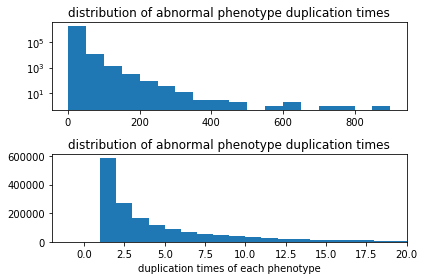

In [18]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.hist(abnormal_occurrence.n, 
        bins = np.arange(0, np.max(abnormal_occurrence.n), 50))
plt.yscale('log')
plt.title('distribution of abnormal phenotype duplication times')
ax = fig.add_subplot(212)
ax.hist(abnormal_occurrence.n, 
        bins = np.arange(0, np.max(abnormal_occurrence.n), 1))
plt.xlim((-2, 20))
plt.xlabel('duplication times of each phenotype')
plt.title('distribution of abnormal phenotype duplication times')
plt.tight_layout()
plt.show()

From the above plot, we conclude that the majority of HPO only occurred once for every patient at each visit. There are some extreme cases where one patient was assigned with hundreds of HPO terms in one admission. They might indicate patients that had lone stay.

In [19]:
stay_duration = pd.read_sql_query("SELECT \
    SUBJECT_ID, HADM_ID, DISCHTIME, ADMITTIME, CEILING(TIME_TO_SEC(TIMEDIFF(DISCHTIME, ADMITTIME))/(3600 * 24)) as days \
    FROM ADMISSIONS", mydb)

In [20]:
stay_duration.head()

,SUBJECT_ID,HADM_ID,DISCHTIME,ADMITTIME,days
0,2,163353,2138-07-21 15:48:00,2138-07-17 19:04:00,4
1,3,145834,2101-10-31 13:58:00,2101-10-20 19:08:00,11
2,4,185777,2191-03-23 18:41:00,2191-03-16 00:28:00,8
3,5,178980,2103-02-04 12:15:00,2103-02-02 04:31:00,3
4,6,107064,2175-06-15 16:00:00,2175-05-30 07:15:00,17


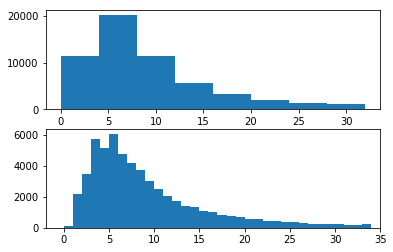

In [21]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.hist(stay_duration.days, 
        bins = np.arange(0, np.max(stay_duration.days), 4))
ax = fig.add_subplot(212)
ax.hist(stay_duration.days, 
        bins = np.arange(0, np.max(stay_duration.days), 1))
plt.xlim((-2, 35))
plt.show()

Most patients stayed in ICU for around 5 days. 

* What is the common diagnosis at each admission?

In [22]:
diagnosis_count = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, \
    CASE \
    WHEN(ICD9_CODE LIKE 'V%') THEN SUBSTRING(ICD9_CODE, 1, 3) \
    WHEN(ICD9_CODE LIKE 'E%') THEN SUBSTRING(ICD9_CODE, 1, 4) \
    ELSE SUBSTRING(ICD9_CODE, 1, 3) END AS ICD9 \
    FROM DIAGNOSES_ICD", mydb)

In [23]:
diagnosis_count.drop_duplicates().groupby('ICD9').size().sort_values(ascending=False).head()

ICD9
401    21305
427    17226
276    15101
272    14558
414    14410
dtype: int64

In [24]:
diagnosis_count.head(n = 10)

,SUBJECT_ID,HADM_ID,ICD9
0,2,163353,V30
1,2,163353,V05
2,2,163353,V29
3,3,145834,038
4,3,145834,785
5,3,145834,584
6,3,145834,427
7,3,145834,410
8,3,145834,428
9,3,145834,682


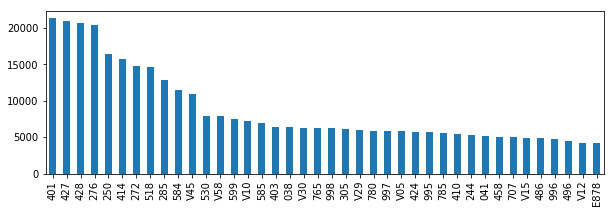

In [25]:
diagnosis_count.ICD9.value_counts().head(n = 40).plot(kind='bar')
fig = plt.gcf()
fig.set_size_inches(10, 3)
plt.show()

The top diagnosis codes are:

* 401 Essential hypertension
* 427 Cardiac dysrhythmias
* 428 Heart failure
* 276 Disorders of fluid, electrolyte, and acid-base balance
* 414 Other forms of chronic ischemic heart disease
* 272 Disorders of lipoid metabolism
* 518 Other diseases of lung
* 285 Other and unspecified anemias
* 584 Acute renal failure
* V45 Other postprocedural states

## Method 1 --SKIP TO Method 3

Now we can try to determine the mutual information content for one diagnosis: Heart failure. Our algorithm is like the following:
* Group patient+admissions into two groups: having code 428 and not having it;
* For each group, count total patient+admission, count patient+admission having Phenotype X or not. 
* For each group, count total patient+admission, count patient+admission having Phenotype Y or not.
* For each group, count total patient+admission, count patient+admission having Phenotype XY, X NOT Y, Y NOT X, NOT X NOT Y. 

We look at what are the commonly seen abnormalities for heart failure patients. We count each phenotype once if they happen multiple times during one admission for each patient. 

In [26]:
pheno_heart_failure = pd.read_sql_query("WITH p AS (SELECT DISTINCT SUBJECT_ID, HADM_ID FROM DIAGNOSES_ICD WHERE ICD9_CODE LIKE '428%'), \
    c AS (SELECT DISTINCT SUBJECT_ID, HADM_ID, MAP_TO FROM combined WHERE NEGATED = 'F') \
    SELECT DISTINCT c.MAP_TO, count(DISTINCT c.SUBJECT_ID, c.HADM_ID, c.MAP_TO) AS count \
FROM c JOIN p ON c.SUBJECT_ID = p.SUBJECT_ID AND c.HADM_ID = p.HADM_ID GROUP BY c.MAP_TO ORDER BY count DESC", mydb)

In [27]:
pheno_heart_failure.head(n = 10)

,MAP_TO,count
0,HP:0003074,12079
1,HP:0001943,12040
2,HP:0031851,11871
3,HP:0003138,11798
4,HP:0020062,11055
5,HP:0002901,10839
6,HP:0020059,10686
7,HP:0012085,10670
8,HP:0020060,10559
9,HP:0020063,10448


The result shows that the most frequent top 6 abnormal phenotypes for patients diagnosed with heart failure: 

* HP:0003074 Hyperglycemia
* HP:0001943 Hypoglycemia
* HP:0031851 Reduced hematocrit
* HP:0003138 Increased blood urea nitrogen
* HP:0020062 Decreased hemoglobin concentration
* HP:0002901 Hypocalcemia

Calculate I(HP:0003074 | heart failure). 
To do this, we need a table for (subject, admission, hasPhenotype) for HP:0003074; then another table for (subject, admission, hasDiagnosis) for ICD9:428\*. Then we can join them together on (subject, admission). Finally, calculate frequencies of (phenotype | diagnosis).

In [28]:
pd.read_sql_query("SELECT DISTINCT SUBJECT_ID, HADM_ID, IF (ICD9_CODE LIKE '428%', 'Y', 'N') AS hasDiagnosis FROM DIAGNOSES_ICD LIMIT 10", mydb)
    

,SUBJECT_ID,HADM_ID,hasDiagnosis
0,2,163353,N
1,3,145834,N
2,3,145834,Y
3,4,185777,N
4,5,178980,N
5,6,107064,N
6,7,118037,N
7,8,159514,N
8,9,150750,N
9,9,150750,Y


In [29]:
pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, IF(SUM(MAP_TO = 'HP:0003074') > 0, 'Y', 'N') AS hasPhenotype \
    FROM combined \
    where NEGATED = 'F' AND HADM_ID IS NOT NULL \
    GROUP BY SUBJECT_ID, HADM_ID \
    LIMIT 10", mydb)

,SUBJECT_ID,HADM_ID,hasPhenotype
0,2,163353,N
1,3,145834,Y
2,4,185777,Y
3,5,178980,N
4,6,107064,Y
5,7,118037,N
6,8,159514,N
7,9,150750,Y
8,10,184167,N
9,11,194540,Y


In [52]:
pd.read_sql_query("SELECT * FROM combined LIMIT 10", mydb)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,NEGATED,MAP_TO
0,1,2,163353,51143,2138-07-17 20:48:00,U,ERROR3
1,2,2,163353,51144,2138-07-17 20:48:00,T,HP:0011991
2,3,2,163353,51146,2138-07-17 20:48:00,T,HP:0031806
3,4,2,163353,51200,2138-07-17 20:48:00,T,HP:0001879
4,5,2,163353,51221,2138-07-17 20:48:00,F,HP:0031851
5,6,2,163353,51222,2138-07-17 20:48:00,F,HP:0020062
6,7,2,163353,51244,2138-07-17 20:48:00,T,HP:0040088
7,8,2,163353,51248,2138-07-17 20:48:00,F,HP:0025547
8,9,2,163353,51249,2138-07-17 20:48:00,F,HP:0025547
9,10,2,163353,51250,2138-07-17 20:48:00,F,HP:0025066


In [161]:
p1 = pd.read_sql_query("WITH \
    l AS \
        (SELECT DISTINCT SUBJECT_ID, HADM_ID, IF (ICD9_CODE LIKE '428%', 'Y', 'N') AS hasDiagnosis \
        FROM DIAGNOSES_ICD), \
    r AS \
        (SELECT SUBJECT_ID, HADM_ID, \
        IF(SUM(MAP_TO = 'HP:0003074') > 0, 'Y', 'N') AS hasPhenotype1, \
        IF(SUM(MAP_TO = 'HP:0002850') > 0, 'Y', 'N') AS hasPhenotype2 \
        FROM combined \
        where NEGATED = 'F' AND HADM_ID IS NOT NULL \
        GROUP BY SUBJECT_ID, HADM_ID) \
    SELECT l.SUBJECT_ID, l.HADM_ID, l.hasDiagnosis, r.hasPhenotype1, r.hasPhenotype2 \
    FROM l LEFT JOIN r ON l.SUBJECT_ID = r.SUBJECT_ID AND l.HADM_ID = r.HADM_ID", mydb)

In [162]:
p1.head()

,SUBJECT_ID,HADM_ID,hasDiagnosis,hasPhenotype1,hasPhenotype2
0,2,163353,N,N,N
1,3,145834,N,Y,N
2,3,145834,Y,Y,N
3,4,185777,N,Y,N
4,5,178980,N,N,N


Now that we have the phenotype-diagnosis table, we can compute I(P|D).

Calculate p(P = 'Y'), p(D = 'Y'), 
p(P = 'Y' and D = 'Y'), p(P = 'N' and D = 'Y'), p(P = 'Y' and D = 'N'), p(P = 'N' and D = 'N')


In [108]:
def mutual_information(dataset, phenotype):
    """
    pPYDY = sum(np.logical_and(p == 'Y', d == 'Y')) / SIZE
    pPNDY = sum(np.logical_and(p == 'N', d == 'Y')) / SIZE
    pPYDN = sum(np.logical_and(p == 'Y', d == 'N')) / SIZE
    pPNDN = sum(np.logical_and(p == 'N', d == 'N')) / SIZE
    """
    p = dataset[phenotype]
    d = dataset['hasDiagnosis']
    SIZE = len(dataset)
    pPY = sum(p == 'Y') / SIZE
    pPN = 1 - pPY
    pDY = sum(d == 'Y') / SIZE
    pDN = 1 - pDY
    temp = dataset.groupby([phenotype, 'hasDiagnosis']).size()
    if len(temp) < 4:
        return (99.99)
    pPYDY = temp.loc['Y', 'Y'] / SIZE
    pPNDY = temp.loc['N', 'Y'] / SIZE
    pPYDN = temp.loc['Y', 'N'] / SIZE
    pPNDN = temp.loc['N', 'N'] / SIZE
    
    I = pPYDY * np.log2(pPYDY / (pPY * pDY)) + \
        pPNDY * np.log2(pPNDY / (pPN * pDY)) + \
        pPYDN * np.log2(pPYDN / (pPY * pDN)) + \
        pPNDN * np.log2(pPNDN / (pPN * pDN))
        
    return(I)

In [163]:
Ip1d = mutual_information(p1, phenotype = 'hasPhenotype1')
Ip2d = mutual_information(p1, phenotype = 'hasPhenotype2')

In [164]:
print(Ip1d)
print(Ip2d)

-0.0075683796680602825
-0.02569630460172535


In [173]:
def mutual_information2(dataset):
    p1 = dataset['hasPhenotype1']
    p2 = dataset['hasPhenotype2']
    d = dataset['hasDiagnosis']
    SIZE = len(dataset)
    p1Y = sum(p1 == 'Y') / SIZE
    p2Y = sum(p2 == 'Y') / SIZE
    pDY = sum(d == 'Y') / SIZE
    pDN = 1 - pDY
    
    """    
    pPYY = sum(np.logical_and(p1 == 'Y', p2 == 'Y')) / SIZE
    pPYN = sum(np.logical_and(p1 == 'Y', p2 == 'N')) / SIZE
    pPNY = sum(np.logical_and(p1 == 'N', p2 == 'Y')) / SIZE
    pPNN = sum(np.logical_and(p1 == 'N', p2 == 'N')) / SIZE
    """
    
    temp1 = dataset.groupby(['hasPhenotype1', 'hasPhenotype2']).size()
    if len(temp1) < 4:
        print(temp1)
        return (-99.99)
    pPYY = temp1.loc(axis=0)['Y', 'Y'] / SIZE
    pPYN = temp1.loc(axis=0)['Y', 'N'] / SIZE
    pPNY = temp1.loc(axis=0)['N', 'Y'] / SIZE
    pPNN = temp1.loc(axis=0)['N', 'N'] / SIZE

    """
    pPYYDY = sum(np.logical_and(np.logical_and(p1 == 'Y', p2 == 'Y'), d == 'Y')) / SIZE
    pPYNDY = sum(np.logical_and(np.logical_and(p1 == 'Y', p2 == 'N'), d == 'Y')) / SIZE
    pPNYDY = sum(np.logical_and(np.logical_and(p1 == 'N', p2 == 'Y'), d == 'Y')) / SIZE
    pPNNDY = sum(np.logical_and(np.logical_and(p1 == 'N', p2 == 'N'), d == 'Y')) / SIZE
    pPYYDN = sum(np.logical_and(np.logical_and(p1 == 'Y', p2 == 'Y'), d == 'N')) / SIZE
    pPYNDN = sum(np.logical_and(np.logical_and(p1 == 'Y', p2 == 'N'), d == 'N')) / SIZE
    pPNYDN = sum(np.logical_and(np.logical_and(p1 == 'N', p2 == 'Y'), d == 'N')) / SIZE
    pPNNDN = sum(np.logical_and(np.logical_and(p1 == 'N', p2 == 'N'), d == 'N')) / SIZE
    """
    
    temp2 = dataset.groupby(['hasPhenotype1', 'hasPhenotype2', 'hasDiagnosis']).size()
    if len(temp2) != 8:
        print(temp2)
        return (-99.99)
    pPYYDY = temp2.loc(axis=0)['Y', 'Y', 'Y'] / SIZE
    pPYNDY = temp2.loc(axis=0)['Y', 'N', 'Y'] / SIZE
    pPNYDY = temp2.loc(axis=0)['N', 'Y', 'Y'] / SIZE
    pPNNDY = temp2.loc(axis=0)['N', 'N', 'Y'] / SIZE
    pPYYDN = temp2.loc(axis=0)['Y', 'Y', 'N'] / SIZE
    pPYNDN = temp2.loc(axis=0)['Y', 'N', 'N'] / SIZE
    pPNYDN = temp2.loc(axis=0)['N', 'Y', 'N'] / SIZE
    pPNNDN = temp2.loc(axis=0)['N', 'N', 'N'] / SIZE
    
    I = pPYYDY * np.log2(pPYYDY / (pPYY * pDY)) + \
        pPYNDY * np.log2(pPYNDY / (pPYN * pDY)) + \
        pPNYDY * np.log2(pPNYDY / (pPNY * pDY)) + \
        pPNNDY * np.log2(pPNNDY / (pPNN * pDY)) + \
        pPYYDN * np.log2(pPYYDN / (pPYY * pDN)) + \
        pPYNDN * np.log2(pPYNDN / (pPYN * pDN)) + \
        pPNYDN * np.log2(pPNYDN / (pPNY * pDN)) + \
        pPNNDN * np.log2(pPNNDN / (pPNN * pDN))
        
    return(I)

In [174]:
Ip1p2 = mutual_information2(p1)

hasPhenotype1  hasPhenotype2  hasDiagnosis
N              N              N               15173
                              Y                1415
               Y              N                  16
Y              N              N               42363
                              Y               12006
               Y              N                 231
                              Y                  73
dtype: int64


In [171]:
syn = Ip1p2 - Ip1d - Ip2d

In [172]:
print(syn)

-99.95673531573021


Combine everything together:

    for every diagnosis code,
        (ignore diagnosis codes with all 0 or all 1)
        for every pair of phenotypes,
        (ignore phenotypes with all 0 or all 1)
            calculate synergy

In [130]:
diagnosisSet = diagnosis_count.drop_duplicates().groupby('ICD9').size().sort_values(ascending=False)

In [132]:
print(diagnosisSet.head())

ICD9
401    21305
427    17226
276    15101
272    14558
414    14410
dtype: int64


### Method 1 implementation

In [178]:
def iterate_all_brutal():
    #for diagnosis in diagnosisSet.keys():
    for diagnosis in ['428']:
        if (diagnosisSet[diagnosis] > 10000):
            queryString = "WITH p AS (SELECT DISTINCT SUBJECT_ID, HADM_ID FROM DIAGNOSES_ICD WHERE ICD9_CODE LIKE '{}%'), \
        c AS (SELECT DISTINCT SUBJECT_ID, HADM_ID, MAP_TO FROM combined WHERE NEGATED = 'F') \
        SELECT DISTINCT c.MAP_TO, count(DISTINCT c.SUBJECT_ID, c.HADM_ID, c.MAP_TO) AS count \
    FROM c JOIN p ON c.SUBJECT_ID = p.SUBJECT_ID AND c.HADM_ID = p.HADM_ID GROUP BY c.MAP_TO ORDER BY count DESC".format(diagnosis)
            phenolist = pd.read_sql_query(queryString, mydb)
            phenoSet = phenolist[phenolist['count'] > 100].MAP_TO
            for i in np.arange(len(phenoSet)):
                phenotype1 = phenoSet[i]
                for j in np.arange(i + 1, len(phenoSet)):
                    phenotype2 = phenoSet[j]
                    queryString = "WITH \
                        l AS \
                            (SELECT DISTINCT SUBJECT_ID, HADM_ID, IF (ICD9_CODE LIKE '{}%', 'Y', 'N') AS hasDiagnosis \
                            FROM DIAGNOSES_ICD), \
                        r AS \
                            (SELECT SUBJECT_ID, HADM_ID, \
                            IF(SUM(MAP_TO = '{}') > 0, 'Y', 'N') AS hasPhenotype1, \
                            IF(SUM(MAP_TO = '{}') > 0, 'Y', 'N') AS hasPhenotype2 \
                            FROM combined \
                            where NEGATED = 'F' AND HADM_ID IS NOT NULL \
                            GROUP BY SUBJECT_ID, HADM_ID) \
                        SELECT l.SUBJECT_ID, l.HADM_ID, l.hasDiagnosis, r.hasPhenotype1, r.hasPhenotype2 \
                        FROM l LEFT JOIN r ON l.SUBJECT_ID = r.SUBJECT_ID AND l.HADM_ID = r.HADM_ID".format(diagnosis, phenotype1, phenotype2)
                    p1 = pd.read_sql_query(queryString, mydb)
                    p1 = p1.fillna('N')
                    if (len(p1.hasPhenotype1.unique()) == 2) and (len(p1.hasPhenotype2.unique()) == 2):
                        Ip1d = mutual_information(p1, phenotype = 'hasPhenotype1')
                        Ip2d = mutual_information(p1, phenotype = 'hasPhenotype2')
                        Ip1p2 = mutual_information2(p1)
                        syn = Ip1p2 - Ip1d - Ip2d
                        print("diagnosis = {} phenotype1 = {}, phenotype2 = {}, syn = {}".format(diagnosis, phenotype1, phenotype2, syn))
                        writer.write("diagnosis = {} phenotype1 = {}, phenotype2 = {}, syn = {}\n".format(diagnosis, phenotype1, phenotype2, syn))

In [270]:
# open a writer 
#writer = open('result.txt', 'w+')
# prepare MySQL
start = datetime.datetime.now()
#cursor.execute("DROP TEMPORARY TABLE IF EXISTS combined")
#cursor.execute('''
#        CREATE TEMPORARY TABLE combined AS 
#        SELECT LABEVENTS.ROW_ID, LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, LABEVENTS.ITEMID, LABEVENTS.CHARTTIME, 
#        LabHpo.NEGATED, LabHpo.MAP_TO 
#        FROM LABEVENTS JOIN LabHpo on LABEVENTS.ROW_ID = LabHpo.ROW_ID
#    ''')
#cursor.execute("CREATE INDEX combined_negated ON combined (NEGATED)")
end = datetime.datetime.now()
print('running time: {}s'.format((end - start).total_seconds()))
# run the iteration
#iterate_all_brutal()
#writer.close()

running time: 3e-05s


The above approach has two major issues: 

1. It computes the mutual information between diagnosis and each phenotype for each phenotype pair. We should have saved them so that we compute them only once.
2. It transfers data from MySQL to Pandas. We could use MySQL to do all the work
3. It did not take full advantage of MySQL index.

Therefore, we come up with the following approach.

## Method 2 - SKIP TO Method 3

In [271]:
# note this takes a long time and large disk size to run
def iterate_all_brutal2():
    start = datetime.datetime.now()
    queryString = '''
        WITH

            combined AS(
                SELECT
                    LABEVENTS.ROW_ID, LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, LABEVENTS.ITEMID, LABEVENTS.CHARTTIME,
                    LabHpo.NEGATED, LabHpo.MAP_TO 
                FROM 
                    LABEVENTS JOIN LabHpo on LABEVENTS.ROW_ID = LabHpo.ROW_ID
            ),

            e AS (SELECT DISTINCT SUBJECT_ID, HADM_ID FROM admissions), 
            -- all encounters to analysis
            p AS (
                SELECT 
                    DISTINCT SUBJECT_ID, HADM_ID, '1' as DIAGNOSIS 
                FROM DIAGNOSES_ICD 
                WHERE ICD9_CODE LIKE '{}%'),
            -- encounters that had the desired diagnosis
            d AS (
                SELECT 
                    e.SUBJECT_ID, e.HADM_ID, IF(p.DIAGNOSIS IS NULL, '0', '1') AS DIAGNOSIS 
                FROM 
                    p RIGHT JOIN e ON e.SUBJECT_ID = p.SUBJECT_ID AND e.HADM_ID = p.HADM_ID), 
            -- diagnosis table: showing whether each encounter had the diagnosis code in research or not
            c AS (
                SELECT 
                    DISTINCT SUBJECT_ID, HADM_ID, MAP_TO, '1' AS PRESENT 
                FROM combined 
                WHERE NEGATED = 'F'), 
            -- table of abnormal phenotypes from lab tests
            l AS (
                SELECT 
                    DISTINCT c.MAP_TO, count(DISTINCT c.SUBJECT_ID, c.HADM_ID, c.MAP_TO) AS count 
                FROM 
                    c JOIN p ON c.SUBJECT_ID = p.SUBJECT_ID AND c.HADM_ID = p.HADM_ID 
                GROUP BY 
                    c.MAP_TO 
                ORDER BY 
                    count DESC),
            -- count how many encounters does a phenotype occur 
            ls AS (
                SELECT 
                    MAP_TO 
                FROM l 
                WHERE count > 5), 
            -- list of phenotypes to analyze: we limit out analysis to those phenotypes that happened at least N times
            hp AS (
                SELECT 
                    e.SUBJECT_ID, e.HADM_ID, ls.MAP_TO 
                FROM 
                    e JOIN ls), 
            -- create a cross product of the encounters * phenotypes: used below
            chp AS (
                SELECT 
                    hp.SUBJECT_ID, hp.HADM_ID, hp.MAP_TO, IF(c.PRESENT IS NULL, '0', '1') AS PRESENT 
                FROM 
                    c RIGHT JOIN hp ON c.SUBJECT_ID = hp.SUBJECT_ID AND c.HADM_ID = hp.HADM_ID AND c.MAP_TO = hp.MAP_TO), 
            -- join phenotypes to the encounters * phenotypes table, 1 if a phenotype is present, 0 if a phenotype is not present
            s AS (
                SELECT 
                    d.SUBJECT_ID, d.HADM_ID, d.DIAGNOSIS, chp.MAP_TO, chp.PRESENT 
                FROM 
                    d RIGHT JOIN chp on d.SUBJECT_ID = chp.SUBJECT_ID AND d.HADM_ID = chp.HADM_ID),
            -- joint table that also shows the diagnosis code 
            -- TODO: join diagnosis while creating hp; ignore this request if we decide to analyze all encounters in one run
            z AS (
                SELECT 
                    MAP_TO, PRESENT, DIAGNOSIS, COUNT(*) AS N 
                FROM 
                    s 
                GROUP BY 
                    MAP_TO, PRESENT, DIAGNOSIS 
                ORDER BY 
                    MAP_TO),
            -- summary counts for each phenotype, phenotype: 0 or 1, diagnosis: 0, 1
            /*
            w AS (
                SELECT 
                    s.SUBJECT_ID, s.HADM_ID, s.DIAGNOSIS, s.MAP_TO, s.PRESENT, ls.MAP_TO AS MAP_TO2 
                FROM 
                    s 
                JOIN ls), -- ORDER BY SUBJECT_ID, HADM_ID, MAP_TO
            -- for the joint table s, add cross product of phenotypes so that we have information of phenotype pairs 
            v AS (
                SELECT 
                    w.*, s.PRESENT AS PRESENT2 
                From 
                    w JOIN s on w.SUBJECT_ID = s.SUBJECT_ID AND w.HADM_ID = s.HADM_ID AND w.MAP_TO2 = s.MAP_TO 
                    -- ORDER BY SUBJECT_ID, HADM_ID, MAP_TO 
                ) 
            -- add value for the second phenotype of each pair
            */
            v AS (
                SELECT 
                    s1.*, s2.MAP_TO AS MAP_TO2, s2.PRESENT AS PRESENT2
                FROM
                    s s1 JOIN s s2 WHERE s1.SUBJECT_ID = s2.SUBJECT_ID AND s1.HADM_ID = s2.HADM_ID
            )

            SELECT 
                DIAGNOSIS, MAP_TO, PRESENT, MAP_TO2, PRESENT2, count(*) AS N 
            FROM 
                v 
            GROUP BY 
                DIAGNOSIS, MAP_TO, PRESENT, MAP_TO2, PRESENT2 
            -- ORDER BY 
            --    MAP_TO, MAP_TO2


        '''.format('428')


    data = pd.read_sql_query(queryString, mydb)

    end = datetime.datetime.now()
    print('running time: {}s'.format((end - start).total_seconds()))
    return data

The above method looks okay, but requires a lot of hard disk space. The reason is that it tries to create many large temporary tables and has to perform a self join of a large table. Therefore, we propose the following method, which works nicely. 

## Method 3 - WORKING !

An improved Algorithm:
    
    * Create a table with SUBJECT_ID, HADM_ID, DIAGNOSIS, MAP_TO
    * Get the set of phenotypes to analyze, put it in python
    * Iterate the phenotype set:
        For Phenotype 1 in Set:
            For Phenotype 2 in Set (After Phenotype 1):
                Create a jointed table with (SUBJECT_ID, HADM_ID, DIAGNOSIS, PHENOTYPE1, PHENOTYPE 2)
                Count after group by (Diagnosis, Phenotype 1, Phenotype 2), output this table to python (Add name of Phenotype 1 and Phenotype 2)
     
We will create temporary tables for intermediate results, and also create indices to speed up following operations.

In [5]:
def diagnosis_set():
    diagnosis_count = pd.read_sql_query("SELECT SUBJECT_ID, HADM_ID, \
        CASE \
        WHEN(ICD9_CODE LIKE 'V%') THEN SUBSTRING(ICD9_CODE, 1, 3) \
        WHEN(ICD9_CODE LIKE 'E%') THEN SUBSTRING(ICD9_CODE, 1, 4) \
        ELSE SUBSTRING(ICD9_CODE, 1, 3) END AS ICD9 \
        FROM DIAGNOSES_ICD", mydb)
    diagnosisSet = diagnosis_count.drop_duplicates().groupby('ICD9').size().sort_values(ascending=False)
    return diagnosisSet

In [86]:
diagnosis = diagnosis_set()

In [87]:
diagnosis['428']

13608

In [6]:
#/*This is abnormal phenotypes. It is possible that one */
def createAbnormalPhenotypeTable(threshold, force_update=True):
    if force_update:
        cursor.execute('''DROP TABLE IF EXISTS p''')           
    cursor.execute('''
                CREATE TEMPORARY TABLE IF NOT EXISTS p
                WITH abnorm AS (
                    SELECT
                        LABEVENTS.SUBJECT_ID, LABEVENTS.HADM_ID, LabHpo.MAP_TO
                    FROM 
                        LABEVENTS 
                    JOIN LabHpo on LABEVENTS.ROW_ID = LabHpo.ROW_ID
                    WHERE LabHpo.NEGATED = 'F')
                SELECT SUBJECT_ID, HADM_ID, MAP_TO
                FROM abnorm 
                GROUP BY SUBJECT_ID, HADM_ID, MAP_TO
                HAVING COUNT(*) > {}
                -- parameter to control how to define an abnormal phenotype is present.
            '''.format(threshold))
    cursor.execute('CREATE INDEX p_idx01 ON p (SUBJECT_ID, HADM_ID)')
    cursor.execute('CREATE INDEX p_idx02 ON p (MAP_TO);')

In [90]:
createAbnormalPhenotypeTable(1, False)

In [92]:
pd.read_sql_query('select * from p limit 5', mydb)

,SUBJECT_ID,HADM_ID,MAP_TO
0,2,163353.0,HP:0025547
1,3,NaN,HP:0003259
2,3,NaN,HP:0001943
3,3,NaN,HP:0003138
4,3,NaN,HP:0031851


In [7]:
def selectEncounters(force_update=True):
    if force_update:
        cursor.execute('DROP TEMPORARY TABLE IF EXISTS a')
    cursor.execute('''
                CREATE TEMPORARY TABLE IF NOT EXISTS a 
                SELECT 
                    DISTINCT SUBJECT_ID, HADM_ID 
                FROM admissions
                -- This is admissions that we want to analyze, remove 'LIMIT 100' to analyze all
                ''')
    return pd.read_sql('SELECT COUNT(*) FROM a', mydb).iloc[0,0]

In [102]:
selectEncounters(force_update=True)

58976

In [8]:
def createDiagnosisTable(diagnosis, force_update=True):
    if force_update:
        cursor.execute('''DROP TEMPORARY TABLE IF EXISTS j1 ''')
    cursor.execute('''
                CREATE TEMPORARY TABLE IF NOT EXISTS j1 
                WITH 
                    d AS (
                        SELECT 
                            DISTINCT SUBJECT_ID, HADM_ID, '1' AS DIAGNOSIS
                        FROM 
                            DIAGNOSES_ICD 
                        WHERE ICD9_CODE LIKE '{}%')
                    -- This is encounters with positive diagnosis

                SELECT 
                    a.SUBJECT_ID, a.HADM_ID, IF(d.DIAGNOSIS IS NULL, '0', '1') AS DIAGNOSIS
                FROM 
                    a
                LEFT JOIN
                    d ON a.SUBJECT_ID = d.SUBJECT_ID AND a.HADM_ID = d.HADM_ID       
                /* -- This is the first join for diagnosis (0, or 1) */    
                '''.format(diagnosis))
    cursor.execute('''CREATE INDEX j1_idx01 ON j1 (SUBJECT_ID, HADM_ID)''')

In [104]:
createDiagnosisTable('428', True)

In [105]:
pd.read_sql_query('select * from j1 limit 5', mydb)

,SUBJECT_ID,HADM_ID,DIAGNOSIS
0,2,163353,0
1,3,145834,1
2,4,185777,0
3,5,178980,0
4,6,107064,0


In [9]:
def phenolist(diagnosis):
    """
    After defining whether each patient*encounter has a certain phenotypes, 
    count how many patient*encounter for each phenotype. """
    phenolistTable = pd.read_sql_query('''
        WITH pd AS(
            SELECT p.*
            FROM 
                p JOIN (SELECT 
                            DISTINCT SUBJECT_ID, HADM_ID, '1' AS DIAGNOSIS
                        FROM 
                            DIAGNOSES_ICD 
                        WHERE ICD9_CODE LIKE '{}%') AS d
                ON p.SUBJECT_ID = d.SUBJECT_ID AND p.HADM_ID = d.HADM_ID)
        SELECT 
            MAP_TO, COUNT(*) AS N
        FROM pd
        GROUP BY MAP_TO
        '''.format(diagnosis), mydb)
    #phenolistTable = phenolistTable.set_index('MAP_TO')
    return phenolistTable

In [ ]:
pl = phenolist('428') 

In [242]:
phenoSet = pl[pl['N'] > 1000].reset_index().MAP_TO
print(phenoSet)

0     HP:0020062
1     HP:0003138
2     HP:0031851
3     HP:0003236
4     HP:0012085
5     HP:0008151
6     HP:0020060
7     HP:0011031
8     HP:0002902
9     HP:0410174
10    HP:0001899
11    HP:0020063
12    HP:0001888
13    HP:0020059
14    HP:0001943
15    HP:0032067
16    HP:0001974
17    HP:0002907
18    HP:0002151
19    HP:0012416
20    HP:0032368
21    HP:0012418
22    HP:0003074
23    HP:0032369
24    HP:0003113
25    HP:0003645
26    HP:0003073
27    HP:0025547
28    HP:0012101
29    HP:0003228
30    HP:0002901
31    HP:0002905
32    HP:0011423
33    HP:0002148
34    HP:0031965
35    HP:0012417
36    HP:0012419
37    HP:0002153
38    HP:0031964
39    HP:0003259
40    HP:0003282
41    HP:0031962
42    HP:0032066
43    HP:0025435
44    HP:0002918
45    HP:0002900
46    HP:0001873
47    HP:0032198
48    HP:0031956
49    HP:0003573
50    HP:0025066
51    HP:0001894
52    HP:0002917
53    HP:0025548
54    HP:0005518
55    HP:0003155
56    HP:0032232
Name: MAP_TO, dtype: object


In [10]:
def diagnosisAndPhenotype1(phenotype):
    cursor.execute('''
        DROP TEMPORARY TABLE IF EXISTS p1''')
    cursor.execute('''
        CREATE TEMPORARY TABLE p1
        SELECT j1.*, IF(s.MAP_TO IS NULL, '0', '1') AS PHENOTYPE1
        FROM j1 
        LEFT JOIN 
        (SELECT * FROM p WHERE p.MAP_TO = '{}') AS s 
        ON j1.SUBJECT_ID = s.SUBJECT_ID AND j1.HADM_ID = s.HADM_ID 
    '''.format(phenotype))
    cursor.execute('CREATE INDEX p1_idx01 ON p1 (SUBJECT_ID, HADM_ID)')
    # count summary statistics for one phenotype
    return pd.read_sql_query('''
        SELECT 
            DIAGNOSIS, PHENOTYPE1 AS PHENOTYPE, COUNT(*) AS N 
        FROM p1
        GROUP BY 
            DIAGNOSIS, PHENOTYPE1  
    ''', mydb)

In [110]:
pd.read_sql_query('''
select * from p LIMIT 5
''', mydb)

,SUBJECT_ID,HADM_ID,MAP_TO
0,2,163353.0,HP:0025547
1,3,NaN,HP:0003259
2,3,NaN,HP:0001943
3,3,NaN,HP:0003138
4,3,NaN,HP:0031851


In [11]:
def diagnosisAndPhenotype2(phenotype):
    result = pd.read_sql_query('''
        WITH c AS (
        SELECT p1.*, IF(s.MAP_TO IS NULL, '0', '1') AS PHENOTYPE2
        FROM p1 
        LEFT JOIN (SELECT * FROM p WHERE p.MAP_TO = '{}') AS s 
        ON p1.SUBJECT_ID = s.SUBJECT_ID AND p1.HADM_ID = s.HADM_ID 
        )
        SELECT DIAGNOSIS, PHENOTYPE1, PHENOTYPE2, COUNT(*) AS N
        FROM c
        GROUP BY DIAGNOSIS, PHENOTYPE1, PHENOTYPE2
    '''.format(phenotype), mydb)
    return result

In [115]:
createDiagnosisTable(diagnosis='428')
diagnosisAndPhenotype1(phenotype='HP:0025547')


,DIAGNOSIS,PHENOTYPE,N
0,0,1,4755
1,1,0,10575
2,0,0,40613
3,1,1,3033


In [116]:
diagnosisAndPhenotype2(phenotype='HP:0003259')

,DIAGNOSIS,PHENOTYPE1,PHENOTYPE2,N
0,0,1,0,3133
1,1,0,1,4590
2,0,0,0,34672
3,0,0,1,5941
4,1,1,1,1775
5,0,1,1,1622
6,1,0,0,5985
7,1,1,0,1258


In [272]:
def iterate_all_brutal_v3():
    summary_statistics1 = pd.DataFrame(data={'DIAGNOSIS_CODE':[], 
                       'P':[], 
                       'DIAGNOSIS':[], 
                       'PHENOTYPE':[], 
                       'N':[]},
                columns = ['DIAGNOSIS_CODE', 'P', 'DIAGNOSIS', 'PHENOTYPE', 'N'])

    summary_statistics2 = pd.DataFrame(data={'DIAGNOSIS_CODE':[], 
                       'P1':[], 
                       'P2':[], 
                       'DIAGNOSIS':[], 
                       'PHENOTYPE1':[], 
                       'PHENOTYPE2':[], 
                       'N':[]},
                columns = ['DIAGNOSIS_CODE', 'P1', 'P2', 'DIAGNOSIS', 'PHENOTYPE1', 'PHENOTYPE2', 'N'])
    diagnosisSet = diagnosis_set()
    createAbnormalPhenotypeTable(1, force_update=True)
    N = selectEncounters(force_update=True)
    #for diagnosis in diagnosisSet.keys():
    for diagnosis in ['428']:
        if (diagnosisSet[diagnosis] > 10000):
        #/*This is abnormal phenotypes. It is possible that one */
            createDiagnosisTable(diagnosis)
            pl = phenolist(diagnosis)
            phenoSet = pl[pl['N'] > 1000].reset_index().MAP_TO
            # compute the mutual information of each phenotype and diagnosis
            for i in np.arange(len(phenoSet)):
                phenotype1 = phenoSet[i]
                result1 = diagnosisAndPhenotype1(phenotype1)
                result1['DIAGNOSIS_CODE']= diagnosis
                result1['P'] = phenotype1
                summary_statistics1 = summary_statistics1.append(result1)
                for j in np.arange(i + 1, len(phenoSet)):
                    phenotype2 = phenoSet[j]
                    result2 = diagnosisAndPhenotype2(phenotype2)
                    result2['DIAGNOSIS_CODE']= diagnosis
                    result2['P1'] = phenotype1
                    result2['P2'] = phenotype2
                    summary_statistics2 = summary_statistics2.append(result2)
                    print('finishing phenotype1 ={}, phenotype2={}'.format(phenotype1, phenotype2))    
    return N, summary_statistics1, summary_statistics2                   

This improved method takes about 30 min - 1 hour to complete.

In [120]:
start = datetime.datetime.now()
N, s1, s2 = iterate_all_brutal_v3() 
end = datetime.datetime.now()
print('running time: {}s'.format((end - start).total_seconds()))

finishing phenotype1 =HP:0020062, phenotype2=HP:0003138
finishing phenotype1 =HP:0020062, phenotype2=HP:0031851
finishing phenotype1 =HP:0020062, phenotype2=HP:0003236
finishing phenotype1 =HP:0020062, phenotype2=HP:0012085
finishing phenotype1 =HP:0020062, phenotype2=HP:0008151
finishing phenotype1 =HP:0020062, phenotype2=HP:0020060
finishing phenotype1 =HP:0020062, phenotype2=HP:0011031
finishing phenotype1 =HP:0020062, phenotype2=HP:0002902
finishing phenotype1 =HP:0020062, phenotype2=HP:0410174
finishing phenotype1 =HP:0020062, phenotype2=HP:0001899
finishing phenotype1 =HP:0020062, phenotype2=HP:0020063
finishing phenotype1 =HP:0020062, phenotype2=HP:0001888
finishing phenotype1 =HP:0020062, phenotype2=HP:0020059
finishing phenotype1 =HP:0020062, phenotype2=HP:0001943
finishing phenotype1 =HP:0020062, phenotype2=HP:0032067
finishing phenotype1 =HP:0020062, phenotype2=HP:0001974
finishing phenotype1 =HP:0020062, phenotype2=HP:0002907
finishing phenotype1 =HP:0020062, phenotype2=HP:

finishing phenotype1 =HP:0031851, phenotype2=HP:0003259
finishing phenotype1 =HP:0031851, phenotype2=HP:0003282
finishing phenotype1 =HP:0031851, phenotype2=HP:0031962
finishing phenotype1 =HP:0031851, phenotype2=HP:0032066
finishing phenotype1 =HP:0031851, phenotype2=HP:0025435
finishing phenotype1 =HP:0031851, phenotype2=HP:0002918
finishing phenotype1 =HP:0031851, phenotype2=HP:0002900
finishing phenotype1 =HP:0031851, phenotype2=HP:0001873
finishing phenotype1 =HP:0031851, phenotype2=HP:0032198
finishing phenotype1 =HP:0031851, phenotype2=HP:0031956
finishing phenotype1 =HP:0031851, phenotype2=HP:0003573
finishing phenotype1 =HP:0031851, phenotype2=HP:0025066
finishing phenotype1 =HP:0031851, phenotype2=HP:0001894
finishing phenotype1 =HP:0031851, phenotype2=HP:0002917
finishing phenotype1 =HP:0031851, phenotype2=HP:0025548
finishing phenotype1 =HP:0031851, phenotype2=HP:0005518
finishing phenotype1 =HP:0031851, phenotype2=HP:0003155
finishing phenotype1 =HP:0031851, phenotype2=HP:

finishing phenotype1 =HP:0008151, phenotype2=HP:0002901
finishing phenotype1 =HP:0008151, phenotype2=HP:0002905
finishing phenotype1 =HP:0008151, phenotype2=HP:0011423
finishing phenotype1 =HP:0008151, phenotype2=HP:0002148
finishing phenotype1 =HP:0008151, phenotype2=HP:0031965
finishing phenotype1 =HP:0008151, phenotype2=HP:0012417
finishing phenotype1 =HP:0008151, phenotype2=HP:0012419
finishing phenotype1 =HP:0008151, phenotype2=HP:0002153
finishing phenotype1 =HP:0008151, phenotype2=HP:0031964
finishing phenotype1 =HP:0008151, phenotype2=HP:0003259
finishing phenotype1 =HP:0008151, phenotype2=HP:0003282
finishing phenotype1 =HP:0008151, phenotype2=HP:0031962
finishing phenotype1 =HP:0008151, phenotype2=HP:0032066
finishing phenotype1 =HP:0008151, phenotype2=HP:0025435
finishing phenotype1 =HP:0008151, phenotype2=HP:0002918
finishing phenotype1 =HP:0008151, phenotype2=HP:0002900
finishing phenotype1 =HP:0008151, phenotype2=HP:0001873
finishing phenotype1 =HP:0008151, phenotype2=HP:

finishing phenotype1 =HP:0002902, phenotype2=HP:0002901
finishing phenotype1 =HP:0002902, phenotype2=HP:0002905
finishing phenotype1 =HP:0002902, phenotype2=HP:0011423
finishing phenotype1 =HP:0002902, phenotype2=HP:0002148
finishing phenotype1 =HP:0002902, phenotype2=HP:0031965
finishing phenotype1 =HP:0002902, phenotype2=HP:0012417
finishing phenotype1 =HP:0002902, phenotype2=HP:0012419
finishing phenotype1 =HP:0002902, phenotype2=HP:0002153
finishing phenotype1 =HP:0002902, phenotype2=HP:0031964
finishing phenotype1 =HP:0002902, phenotype2=HP:0003259
finishing phenotype1 =HP:0002902, phenotype2=HP:0003282
finishing phenotype1 =HP:0002902, phenotype2=HP:0031962
finishing phenotype1 =HP:0002902, phenotype2=HP:0032066
finishing phenotype1 =HP:0002902, phenotype2=HP:0025435
finishing phenotype1 =HP:0002902, phenotype2=HP:0002918
finishing phenotype1 =HP:0002902, phenotype2=HP:0002900
finishing phenotype1 =HP:0002902, phenotype2=HP:0001873
finishing phenotype1 =HP:0002902, phenotype2=HP:

finishing phenotype1 =HP:0020063, phenotype2=HP:0003259
finishing phenotype1 =HP:0020063, phenotype2=HP:0003282
finishing phenotype1 =HP:0020063, phenotype2=HP:0031962
finishing phenotype1 =HP:0020063, phenotype2=HP:0032066
finishing phenotype1 =HP:0020063, phenotype2=HP:0025435
finishing phenotype1 =HP:0020063, phenotype2=HP:0002918
finishing phenotype1 =HP:0020063, phenotype2=HP:0002900
finishing phenotype1 =HP:0020063, phenotype2=HP:0001873
finishing phenotype1 =HP:0020063, phenotype2=HP:0032198
finishing phenotype1 =HP:0020063, phenotype2=HP:0031956
finishing phenotype1 =HP:0020063, phenotype2=HP:0003573
finishing phenotype1 =HP:0020063, phenotype2=HP:0025066
finishing phenotype1 =HP:0020063, phenotype2=HP:0001894
finishing phenotype1 =HP:0020063, phenotype2=HP:0002917
finishing phenotype1 =HP:0020063, phenotype2=HP:0025548
finishing phenotype1 =HP:0020063, phenotype2=HP:0005518
finishing phenotype1 =HP:0020063, phenotype2=HP:0003155
finishing phenotype1 =HP:0020063, phenotype2=HP:

finishing phenotype1 =HP:0032067, phenotype2=HP:0001974
finishing phenotype1 =HP:0032067, phenotype2=HP:0002907
finishing phenotype1 =HP:0032067, phenotype2=HP:0002151
finishing phenotype1 =HP:0032067, phenotype2=HP:0012416
finishing phenotype1 =HP:0032067, phenotype2=HP:0032368
finishing phenotype1 =HP:0032067, phenotype2=HP:0012418
finishing phenotype1 =HP:0032067, phenotype2=HP:0003074
finishing phenotype1 =HP:0032067, phenotype2=HP:0032369
finishing phenotype1 =HP:0032067, phenotype2=HP:0003113
finishing phenotype1 =HP:0032067, phenotype2=HP:0003645
finishing phenotype1 =HP:0032067, phenotype2=HP:0003073
finishing phenotype1 =HP:0032067, phenotype2=HP:0025547
finishing phenotype1 =HP:0032067, phenotype2=HP:0012101
finishing phenotype1 =HP:0032067, phenotype2=HP:0003228
finishing phenotype1 =HP:0032067, phenotype2=HP:0002901
finishing phenotype1 =HP:0032067, phenotype2=HP:0002905
finishing phenotype1 =HP:0032067, phenotype2=HP:0011423
finishing phenotype1 =HP:0032067, phenotype2=HP:

finishing phenotype1 =HP:0002151, phenotype2=HP:0001873
finishing phenotype1 =HP:0002151, phenotype2=HP:0032198
finishing phenotype1 =HP:0002151, phenotype2=HP:0031956
finishing phenotype1 =HP:0002151, phenotype2=HP:0003573
finishing phenotype1 =HP:0002151, phenotype2=HP:0025066
finishing phenotype1 =HP:0002151, phenotype2=HP:0001894
finishing phenotype1 =HP:0002151, phenotype2=HP:0002917
finishing phenotype1 =HP:0002151, phenotype2=HP:0025548
finishing phenotype1 =HP:0002151, phenotype2=HP:0005518
finishing phenotype1 =HP:0002151, phenotype2=HP:0003155
finishing phenotype1 =HP:0002151, phenotype2=HP:0032232
finishing phenotype1 =HP:0012416, phenotype2=HP:0032368
finishing phenotype1 =HP:0012416, phenotype2=HP:0012418
finishing phenotype1 =HP:0012416, phenotype2=HP:0003074
finishing phenotype1 =HP:0012416, phenotype2=HP:0032369
finishing phenotype1 =HP:0012416, phenotype2=HP:0003113
finishing phenotype1 =HP:0012416, phenotype2=HP:0003645
finishing phenotype1 =HP:0012416, phenotype2=HP:

finishing phenotype1 =HP:0003074, phenotype2=HP:0001894
finishing phenotype1 =HP:0003074, phenotype2=HP:0002917
finishing phenotype1 =HP:0003074, phenotype2=HP:0025548
finishing phenotype1 =HP:0003074, phenotype2=HP:0005518
finishing phenotype1 =HP:0003074, phenotype2=HP:0003155
finishing phenotype1 =HP:0003074, phenotype2=HP:0032232
finishing phenotype1 =HP:0032369, phenotype2=HP:0003113
finishing phenotype1 =HP:0032369, phenotype2=HP:0003645
finishing phenotype1 =HP:0032369, phenotype2=HP:0003073
finishing phenotype1 =HP:0032369, phenotype2=HP:0025547
finishing phenotype1 =HP:0032369, phenotype2=HP:0012101
finishing phenotype1 =HP:0032369, phenotype2=HP:0003228
finishing phenotype1 =HP:0032369, phenotype2=HP:0002901
finishing phenotype1 =HP:0032369, phenotype2=HP:0002905
finishing phenotype1 =HP:0032369, phenotype2=HP:0011423
finishing phenotype1 =HP:0032369, phenotype2=HP:0002148
finishing phenotype1 =HP:0032369, phenotype2=HP:0031965
finishing phenotype1 =HP:0032369, phenotype2=HP:

finishing phenotype1 =HP:0025547, phenotype2=HP:0025435
finishing phenotype1 =HP:0025547, phenotype2=HP:0002918
finishing phenotype1 =HP:0025547, phenotype2=HP:0002900
finishing phenotype1 =HP:0025547, phenotype2=HP:0001873
finishing phenotype1 =HP:0025547, phenotype2=HP:0032198
finishing phenotype1 =HP:0025547, phenotype2=HP:0031956
finishing phenotype1 =HP:0025547, phenotype2=HP:0003573
finishing phenotype1 =HP:0025547, phenotype2=HP:0025066
finishing phenotype1 =HP:0025547, phenotype2=HP:0001894
finishing phenotype1 =HP:0025547, phenotype2=HP:0002917
finishing phenotype1 =HP:0025547, phenotype2=HP:0025548
finishing phenotype1 =HP:0025547, phenotype2=HP:0005518
finishing phenotype1 =HP:0025547, phenotype2=HP:0003155
finishing phenotype1 =HP:0025547, phenotype2=HP:0032232
finishing phenotype1 =HP:0012101, phenotype2=HP:0003228
finishing phenotype1 =HP:0012101, phenotype2=HP:0002901
finishing phenotype1 =HP:0012101, phenotype2=HP:0002905
finishing phenotype1 =HP:0012101, phenotype2=HP:

finishing phenotype1 =HP:0002148, phenotype2=HP:0002153
finishing phenotype1 =HP:0002148, phenotype2=HP:0031964
finishing phenotype1 =HP:0002148, phenotype2=HP:0003259
finishing phenotype1 =HP:0002148, phenotype2=HP:0003282
finishing phenotype1 =HP:0002148, phenotype2=HP:0031962
finishing phenotype1 =HP:0002148, phenotype2=HP:0032066
finishing phenotype1 =HP:0002148, phenotype2=HP:0025435
finishing phenotype1 =HP:0002148, phenotype2=HP:0002918
finishing phenotype1 =HP:0002148, phenotype2=HP:0002900
finishing phenotype1 =HP:0002148, phenotype2=HP:0001873
finishing phenotype1 =HP:0002148, phenotype2=HP:0032198
finishing phenotype1 =HP:0002148, phenotype2=HP:0031956
finishing phenotype1 =HP:0002148, phenotype2=HP:0003573
finishing phenotype1 =HP:0002148, phenotype2=HP:0025066
finishing phenotype1 =HP:0002148, phenotype2=HP:0001894
finishing phenotype1 =HP:0002148, phenotype2=HP:0002917
finishing phenotype1 =HP:0002148, phenotype2=HP:0025548
finishing phenotype1 =HP:0002148, phenotype2=HP:

finishing phenotype1 =HP:0003282, phenotype2=HP:0001894
finishing phenotype1 =HP:0003282, phenotype2=HP:0002917
finishing phenotype1 =HP:0003282, phenotype2=HP:0025548
finishing phenotype1 =HP:0003282, phenotype2=HP:0005518
finishing phenotype1 =HP:0003282, phenotype2=HP:0003155
finishing phenotype1 =HP:0003282, phenotype2=HP:0032232
finishing phenotype1 =HP:0031962, phenotype2=HP:0032066
finishing phenotype1 =HP:0031962, phenotype2=HP:0025435
finishing phenotype1 =HP:0031962, phenotype2=HP:0002918
finishing phenotype1 =HP:0031962, phenotype2=HP:0002900
finishing phenotype1 =HP:0031962, phenotype2=HP:0001873
finishing phenotype1 =HP:0031962, phenotype2=HP:0032198
finishing phenotype1 =HP:0031962, phenotype2=HP:0031956
finishing phenotype1 =HP:0031962, phenotype2=HP:0003573
finishing phenotype1 =HP:0031962, phenotype2=HP:0025066
finishing phenotype1 =HP:0031962, phenotype2=HP:0001894
finishing phenotype1 =HP:0031962, phenotype2=HP:0002917
finishing phenotype1 =HP:0031962, phenotype2=HP:

In [121]:
s1.to_csv('summary_statistics1.csv', index = False)
s2.to_csv('summary_statistics2.csv', index = False)
print('total encounters analyzed: {}'.format(N))

total encounters analyzed: 58976


In [274]:
s1 = pd.read_csv('summary_statistics1.csv')
s2 = pd.read_csv('summary_statistics2.csv')
s1 = s1.loc[s1.DIAGNOSIS_CODE.astype('str') == '428', :]
s2 = s2.loc[s2.DIAGNOSIS_CODE.astype('str') == '428', :]

In [275]:
s1.head()

,DIAGNOSIS,DIAGNOSIS_CODE,N,P,PHENOTYPE
0,0,428,21005.0,HP:0020062,0
1,1,428,10376.0,HP:0020062,1
2,0,428,24363.0,HP:0020062,1
3,1,428,3232.0,HP:0020062,0
4,0,428,27127.0,HP:0003138,0


In [276]:
s2.head()

,DIAGNOSIS,DIAGNOSIS_CODE,N,P1,P2,PHENOTYPE1,PHENOTYPE2
0,0,428,17162.0,HP:0020062,HP:0003138,0,0
1,1,428,8883.0,HP:0020062,HP:0003138,1,1
2,0,428,9965.0,HP:0020062,HP:0003138,1,0
3,0,428,14398.0,HP:0020062,HP:0003138,1,1
4,1,428,2185.0,HP:0020062,HP:0003138,0,1


In [127]:
# This should be returned from SQL calculations
TOTAL_ENCOUNTER = N

In [128]:
def entropy(x):
    '''
    Given the distribution of a random variable, return the entropy
    '''
    T = np.sum(x)
    p = x / T
    p_log = [0 if x == 0 else np.log2(x) for x in p]
    return np.sum(p * p_log)

In [149]:
f1 = s1.loc[:, ['PHENOTYPE', 'P', 'N']] \
    .groupby(['P', 'PHENOTYPE']) \
    .agg({'N': lambda x: sum(x) / TOTAL_ENCOUNTER}) \
    .reset_index() \
    .rename(columns={'N': 'FP'})

In [150]:
f1.head()

,P,PHENOTYPE,FP
0,HP:0001873,0,0.685245
1,HP:0001873,1,0.314755
2,HP:0001888,0,0.745659
3,HP:0001888,1,0.254341
4,HP:0001894,0,0.875085


In [151]:
f2 = s1.loc[:, ['DIAGNOSIS', 'P', 'N']] \
    .groupby(['P', 'DIAGNOSIS']) \
    .agg({'N': lambda x: sum(x) / TOTAL_ENCOUNTER}) \
    .reset_index() \
    .rename(columns={'N': 'DP'})

In [152]:
f2.head()

,P,DIAGNOSIS,DP
0,HP:0001873,0,0.769262
1,HP:0001873,1,0.230738
2,HP:0001888,0,0.769262
3,HP:0001888,1,0.230738
4,HP:0001894,0,0.769262


In [161]:
f3 = s1
f3['prob'] = f3.N / TOTAL_ENCOUNTER
f3 = f3.merge(f1, how = 'left', on = ['P', 'PHENOTYPE']).merge(f2, how = 'left', on = ['P', 'DIAGNOSIS'])
f3['E'] = f3.prob * np.log2(f3.prob / (f3.FP * f3.DP))

In [162]:
f3.head()

,DIAGNOSIS,DIAGNOSIS_CODE,N,P,PHENOTYPE,prob,FP,DP,E
0,0,428,21005.0,HP:0020062,0,0.356162,0.410964,0.769262,0.061251
1,1,428,10376.0,HP:0020062,1,0.175936,0.589036,0.230738,0.065513
2,0,428,24363.0,HP:0020062,1,0.413100,0.589036,0.769262,-0.055112
3,1,428,3232.0,HP:0020062,0,0.054802,0.410964,0.230738,-0.043350
4,0,428,27127.0,HP:0003138,0,0.459967,0.503035,0.769262,0.114680


In [180]:
I = f3.groupby(['P']).agg({'E': sum}).reset_index().rename(columns={'E':'I'})

In [181]:
I.head()

,P,I
0,HP:0001873,0.004634
1,HP:0001888,0.018635
2,HP:0001894,0.000150
3,HP:0001899,0.004737
4,HP:0001943,0.025688


In [233]:
s2.head()

(12768, 8)

In [171]:
F1 = s2.groupby(['P1', 'P2', 'PHENOTYPE1', 'PHENOTYPE2']) \
    .agg({'N':lambda x: sum(x) / TOTAL_ENCOUNTER}) \
    .reset_index() \
    .rename(columns={'N':'FP'})

In [172]:
F1.head()

,P1,P2,PHENOTYPE1,PHENOTYPE2,FP
0,HP:0001873,HP:0001894,0,0,0.586442
1,HP:0001873,HP:0001894,0,1,0.098803
2,HP:0001873,HP:0001894,1,0,0.288643
3,HP:0001873,HP:0001894,1,1,0.026112
4,HP:0001873,HP:0002917,0,0,0.638192


In [173]:
F2 = s2.groupby(['P1', 'P2', 'DIAGNOSIS']) \
    .agg({'N':lambda x: sum(x) / TOTAL_ENCOUNTER}) \
    .reset_index() \
    .rename(columns={'N':'DP'})

In [174]:
F2.head()

,P1,P2,DIAGNOSIS,DP
0,HP:0001873,HP:0001894,0,0.769262
1,HP:0001873,HP:0001894,1,0.230738
2,HP:0001873,HP:0002917,0,0.769262
3,HP:0001873,HP:0002917,1,0.230738
4,HP:0001873,HP:0003155,0,0.769262


In [188]:
F3 = s2
F3['prob'] = F3.N / TOTAL_ENCOUNTER
F3 = F3.merge(F1, how = 'left', on = ['P1', 'P2', 'PHENOTYPE1', 'PHENOTYPE2']) \
    .merge(F2, how = 'left', on = ['P1', 'P2', 'DIAGNOSIS'] )
F3['E'] = F3.prob * np.log2(F3.prob / (F3.FP * F3.DP))
F3.head()

,DIAGNOSIS,DIAGNOSIS_CODE,N,P1,P2,PHENOTYPE1,PHENOTYPE2,prob,FP,DP,E
0,0,428,17162.0,HP:0020062,HP:0003138,0,0,0.291000,0.308753,0.769262,0.085268
1,1,428,8883.0,HP:0020062,HP:0003138,1,1,0.150621,0.394754,0.230738,0.109296
2,0,428,9965.0,HP:0020062,HP:0003138,1,0,0.168967,0.194282,0.769262,0.029914
3,0,428,14398.0,HP:0020062,HP:0003138,1,1,0.244133,0.394754,0.769262,-0.076861
4,1,428,2185.0,HP:0020062,HP:0003138,0,1,0.037049,0.102211,0.230738,0.024142


In [189]:
I2 = F3.groupby(['P1', 'P2']).agg({'E': sum}).reset_index().rename(columns={'E':'II'})

In [194]:
I2.head()

,P1,P2,II
0,HP:0001873,HP:0001894,0.005735
1,HP:0001873,HP:0002917,0.005614
2,HP:0001873,HP:0003155,0.005611
3,HP:0001873,HP:0003573,0.009391
4,HP:0001873,HP:0005518,0.005831


In [191]:
syn = I2.merge(I, how = 'left', left_on = ['P1'], right_on = 'P') \
        .rename(columns = {'I': 'I1'}) \
        .merge(I, how = 'left', left_on = ['P2'], right_on = 'P') \
        .rename(columns = {'I': 'I2'}) \
        .loc[:, ['P1', 'P2', 'II', 'I1', 'I2']]

In [244]:
syn['syn'] = syn['II'] - syn['I1'] - syn['I2']

In [266]:
syn.sort_values(by = 'syn', ascending = False).head(n = 20)

,P1,P2,II,I1,I2,syn
1186,HP:0020062,HP:0020063,0.042316,0.028301,0.007577,0.006439
1130,HP:0020060,HP:0020059,0.039824,0.021014,0.012401,0.006409
1403,HP:0031965,HP:0003573,0.042010,0.033777,0.002275,0.005959
1150,HP:0020062,HP:0001899,0.038278,0.028301,0.004737,0.005241
1356,HP:0031956,HP:0003573,0.008439,0.001309,0.002275,0.004855
1131,HP:0020060,HP:0020063,0.033211,0.021014,0.007577,0.004620
1466,HP:0032067,HP:0032066,0.035642,0.027414,0.003713,0.004515
1260,HP:0025435,HP:0003573,0.013410,0.006633,0.002275,0.004502
1135,HP:0020060,HP:0025548,0.026647,0.021014,0.001236,0.004397
1409,HP:0031965,HP:0025548,0.039338,0.033777,0.001236,0.004325


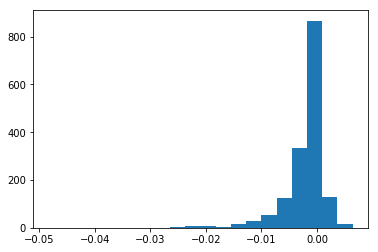

In [267]:
plt.hist(syn.syn, bins = 20)
plt.show()

## Method 4

This method relies on the power of MySQL for doing queies and joins, return a batch of phenotype profiles a time, and then use the power of Numpy to do numeric computation.

Algorithm:

    1. For one diagnosis code, specify the phenotypes to analyze--a list of HPO terms.
    2. For a batch of patient*encounters, return a list of diagnosis codes (1 or 0)
    3. For the same batch of patient*encounters, return a list of phenotypes.
    4. Create a numpy array with dimension (N x P)
    5. Perform numeric computation with Numpy:
        outer product for ++ of PxP.T
        outer product for +- of Px(1-P).T
        outer product for -+ of (1-P)xP
        outer product for -- of (1-P)x(1-P).T
        combine the above with - and + of diagnosis value
        stack them together as a (N x P x P x 8) matrix.
        Step 1 - 5 are performed at each site. The resulting matrix is returned to JAX for final analyze.
    6. Compute pairwise synergy:
        use the multi-dimension array to calculate p(D = 1), p(D = 0), p(P1 * P2)
        compute mutual information of each phenotype in regarding to one diagnosis I(P:D)
        compute mutual information of two phenotypes in regarding to one diagnosis I(P:D)
        compute pairwise synergy
        

In [61]:
def encountersWithDiagnosis(diagnosis):
    cursor.execute('''DROP TEMPORARY TABLE IF EXISTS d''')
    cursor.execute('''
        CREATE TEMPORARY TABLE IF NOT EXISTS d
        SELECT 
            DISTINCT SUBJECT_ID, HADM_ID, '1' AS DIAGNOSIS
        FROM 
            DIAGNOSES_ICD 
        WHERE ICD9_CODE LIKE '{}%'
        -- This is encounters with positive diagnosis
    '''.format(diagnosis))
    cursor.execute('CREATE INDEX d_idx01 ON d(SUBJECT_ID, HADM_ID)')

    
def createPhenotypeSet(diagnosis, threshold=1000):
    cursor.execute('DROP TEMPORARY TABLE IF EXISTS ps')
    cursor.execute('''
            CREATE TEMPORARY TABLE ps
            WITH pd AS(
                SELECT p.*
                FROM 
                    p JOIN (SELECT 
                                DISTINCT SUBJECT_ID, HADM_ID, '1' AS DIAGNOSIS
                            FROM 
                                DIAGNOSES_ICD 
                            WHERE ICD9_CODE LIKE '{}%') AS d
                    ON p.SUBJECT_ID = d.SUBJECT_ID AND p.HADM_ID = d.HADM_ID)
            SELECT 
                MAP_TO, COUNT(*) AS N, '1' AS PHENOTYPE
            FROM pd
            GROUP BY MAP_TO
            HAVING N > {}
            ORDER BY N DESC'''.format(diagnosis, threshold))
    phenoSet = pd.read_sql_query('SELECT * FROM ps', mydb)
    return phenoSet


def batch_query(start_index, end_index):
    cursor.execute('''
                SELECT 
                    COUNT(DISTINCT SUBJECT_ID, HADM_ID) 
                FROM admissions 
                WHERE SUBJECT_ID BETWEEN {} AND {}
                '''.format(start_index, end_index))
    batch_size_actual = cursor.fetchall()[0][0]
    # create diagnosis table
    diagnosisList = pd.read_sql_query('''
                WITH a AS (
                    SELECT DISTINCT SUBJECT_ID, HADM_ID 
                    FROM admissions 
                    WHERE SUBJECT_ID BETWEEN {} AND {})
                SELECT 
                    a.SUBJECT_ID, a.HADM_ID, IF(d.DIAGNOSIS IS NULL, '0', '1') AS DIAGNOSIS
                FROM 
                    a
                LEFT JOIN
                    d ON a.SUBJECT_ID = d.SUBJECT_ID AND a.HADM_ID = d.HADM_ID         
                '''.format(start_index, end_index), mydb)
    # create phenotype profile table
    phenotyle_profile = pd.read_sql_query('''
        WITH 
            a AS (
                    SELECT 
                        DISTINCT SUBJECT_ID, HADM_ID 
                    FROM 
                        admissions 
                    WHERE SUBJECT_ID BETWEEN {} AND {}), 
            c as (
                SELECT a.*, ps.MAP_TO
                FROM a
                JOIN ps),
                -- cross product of all patient*encounter and phenotypes list
            pp as (
                SELECT p.*, '1' AS PHENOTYPE 
                FROM p RIGHT JOIN a 
                ON p.SUBJECT_ID = a.SUBJECT_ID AND p.HADM_ID = a.HADM_ID)

        SELECT c.SUBJECT_ID, c.HADM_ID, c.MAP_TO, IF(pp.PHENOTYPE IS NULL, '0', '1') AS PHENOTYPE 
        FROM pp 
        RIGHT JOIN c ON pp.SUBJECT_ID = c.SUBJECT_ID and pp.HADM_ID = c.HADM_ID AND pp.MAP_TO = c.MAP_TO
        '''.format(start_index, end_index), mydb)
    return batch_size_actual, diagnosisList, phenotyle_profile

In [62]:
def iterate_in_batch():
    batch_size = 100
    # find the set of diagnosis that are worthy to analyze
    diagnosisSet = diagnosis_set()

    # create a temp table for abnormal phenotypes of each patient*encounter that met the threshold
    createAbnormalPhenotypeTable(threshold=1, force_update=True)
    
    for diagnosis in ['428']:
        if (diagnosisSet[diagnosis] > 10000):
            # create a temp table for diagnosis of all patient*encouter to analyze
            encountersWithDiagnosis(diagnosis)

            ## create a list of phenotypes that we want to analyze for the specified disease and preset threshold
            phenoSet = createPhenotypeSet(diagnosis='428', threshold=1000)
            P_SIZE = len(phenoSet)

            ## find the start and end ROW_ID for patient*encounter
            cursor.execute('SELECT MIN(ROW_ID) AS min, MAX(ROW_ID) AS max FROM admissions')
            ADM_ID_START, ADM_ID_END = cursor.fetchall()[0]
            batch_N = ADM_ID_END - ADM_ID_START + 1
            TOTAL_BATCH = math.ceil(batch_N / batch_size) # total number of batches
            for i in np.arange(TOTAL_BATCH):
                start_index = i * batch_size + ADM_ID_START
                if i < TOTAL_BATCH - 1:
                    end_index = start_index + batch_size - 1
                else:
                    end_index = batch_N
                
                batch_size_actual, diagnosisList, phenotyle_profile = batch_query(start_index, end_index)
                
                diagnosisVector = diagnosisList.DIAGNOSIS.values
                phenotypeProfileMatrix = phenotyle_profile.PHENOTYPE.values.reshape([batch_size_actual, P_SIZE])
                print('new batch: start_index={}, end_index={}, batch_size= {}, phenotype_size = {}'.format(start_index, end_index, batch_size_actual, len(phenoSet)))
                # TODO: do numeric computation

This method takes only minutes to run. Note: numeric computation is not counted yet.

In [ ]:
start = datetime.datetime.now()

iterate_in_batch()
   
end = datetime.datetime.now()
print('running time: {}s'.format((end - start).total_seconds()))

In [93]:
cursor.close()
mydb.close()